# Monte-Carlo estimation of equilibrium polarization
To account for non-linear effects in the estimate of the equilibrium polarization we can use particle tracking of a full particle distribution, including in the simulation the stochastic photon emission.

The method is described in detail in:
Z. Duan, M. Bai, D. P. Barber, Q. Qin, "A Monte-Carlo simulation of the equilibrium beam polarization in ultra-high energy electron (positron) storage rings", https://www.sciencedirect.com/science/article/pii/S0168900215005744

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import xpart as xp
import xobjects as xo
import numpy as np
import matplotlib.pyplot as plt

### Load and configure ring model

In [3]:
line = xt.Line.from_json('lattice/lep_sol.json')

Loading line from dict:   0%|          | 0/9667 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
# RF
line['vrfc231'] = 12.65  # qs=0.6 with radiation

In [5]:
# Match tunes to those used during polarization measurements
# https://cds.cern.ch/record/282605
opt = line.match(
    method='4d',
    solve=False,
    vary=xt.VaryList(['kqf', 'kqd'], step=1e-4),
    targets=xt.TargetSet(qx=65.10, qy=71.20, tol=1e-4)
)
opt.solve()

                                             
Optimize - start penalty: 2.635                             
Matching: model call n. 9 penalty = 4.9257e-05              
Optimize - end penalty:  4.92571e-05                            


### Machine with solenoids and spin bumps

In [6]:
line['on_solenoids'] = 1
line['on_spin_bumps'] = 0
line['on_coupling_corrections'] = 1

In [7]:
# Enable radiation (mean mode)
line.configure_radiation('mean')

In [8]:
# Compute equilibrium emittances
tw = line.twiss(spin=True, eneloss_and_damping=True, polarization=True)

### Generate a particle distribution 

In [9]:
# Generate a matched bunch distribution
np.random.seed(0)
particles = xp.generate_matched_gaussian_bunch(
    line=line,
    nemitt_x=tw.eq_nemitt_x,
    nemitt_y=tw.eq_nemitt_y,
    sigma_z=np.sqrt(tw.eq_gemitt_zeta * tw.bets0),
    num_particles=300,
    engine='linear')

In [10]:
# Add stable phase
particles.zeta += tw.zeta[0]
particles.delta += tw.delta[0]

In [11]:
# Initialize spin of all particles along n0
particles.spin_x = tw.spin_x[0]
particles.spin_y = tw.spin_y[0]
particles.spin_z = tw.spin_z[0]

### Simulate bunch evolution with stochastic photon emission

In [12]:
line.configure_spin('auto')
line.configure_radiation(model='quantum')

In [13]:
# Enable parallelization
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads=10))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [14]:
# Track
num_turns=200
line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True,
           with_progress=10)
mon = line.record_last_track

Tracking:   0%|          | 0/200 [00:00<?, ?it/s]

### Fit depolarization time

In [15]:
mask_alive = mon.state > 0
pol_x = mon.spin_x.sum(axis=0)/mask_alive.sum(axis=0)
pol_y = mon.spin_y.sum(axis=0)/mask_alive.sum(axis=0)
pol_z = mon.spin_z.sum(axis=0)/mask_alive.sum(axis=0)
pol = np.sqrt(pol_x**2 + pol_y**2 + pol_z**2)

i_start = 3 # Skip a few turns (small initial mismatch)
pol_to_fit = pol[i_start:]/pol[i_start]
 
# Fit depolarization time (linear fit)
from scipy.stats import linregress
turns = np.arange(len(pol_to_fit))
slope, intercept, r_value, p_value, std_err = linregress(turns, pol_to_fit)
# Calculate depolarization time
t_dep_turns = -1 / slope

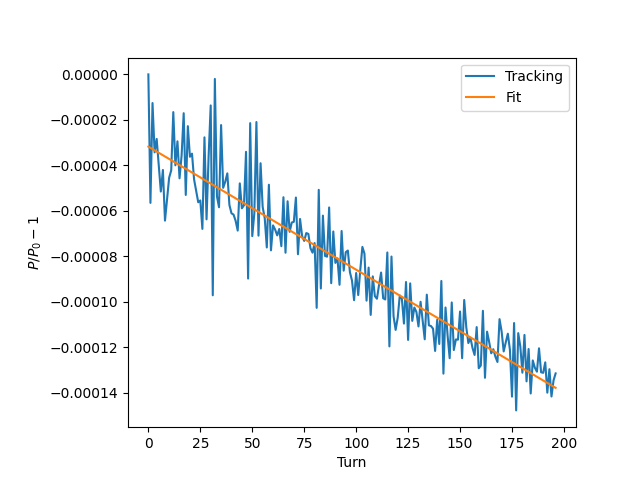

In [16]:
plt.figure()
plt.plot(pol_to_fit-1, label='Tracking')
plt.plot(turns, intercept*np.exp(-turns/t_dep_turns) - 1, label='Fit')
plt.ylabel(r'$P/P_0 - 1$')
plt.xlabel('Turn')
plt.subplots_adjust(left=.2)
plt.legend()

### Compute equilibrium polarization

We use the following result from the reference above

<div>
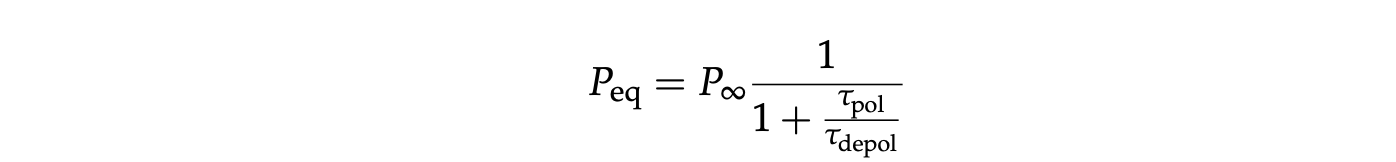
</div>

where $P_\infty$ and $\tau_\text{pol}$ can be estimated knowing $n_0$ and are provided by the twiss:
<div>
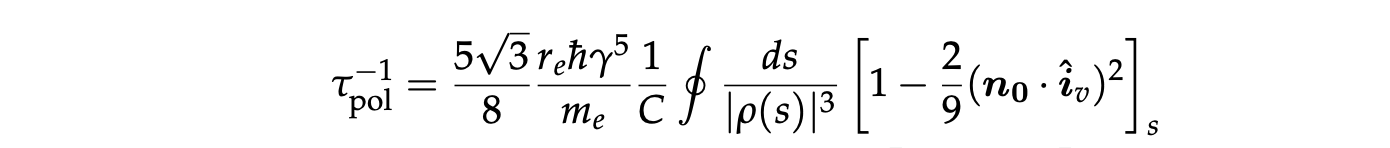
</div>
<div>
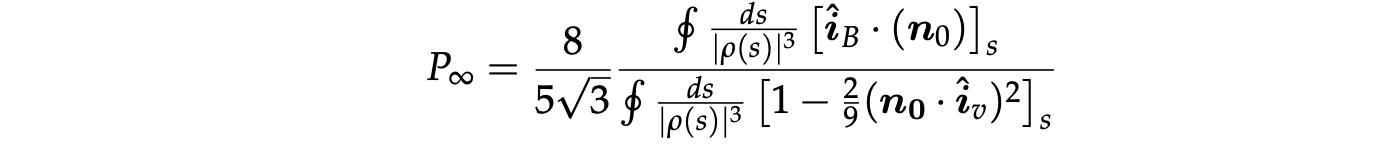
</div>

In [17]:
p_inf = tw['spin_polarization_inf_no_depol']
t_pol_turns = tw['spin_t_pol_component_s']/tw.T_rev0

In [18]:
p_eq = p_inf * 1 / (1 + t_pol_turns/t_dep_turns)

In [19]:
print(f'Equilibrium polarization: {p_eq*100:.2f} %')

Equilibrium polarization: 0.78 %
